In [3]:
import numpy as np
import pandas as pd
import sns
import unicodedata
import re
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


In [4]:
data = pd.read_csv('output.csv')


In [5]:
data.head()

,province,district,street,price_unit,price_value,price_absolute,area,type,front,room,toilet,floor,attributes
0,1,5,Mặt phố C1 TT Nghĩa Tân,1,5.50,5500.0,70.0,1,7.0,2,2,1,"Ô tô, Kinh doanh, Dòng tiền"
1,1,5,Yên Hoà,1,8.58,8580.0,45.0,1,5.0,5,4,4,Ô tô
2,1,5,Cầu Giấy,1,8.65,8650.0,43.0,1,3.6,6,1,5,NaN
3,1,5,Hồ Tùng Mậu,1,28.50,28500.0,100.0,1,6.9,29,29,8,"Ô tô, Dòng tiền, Thang máy"
4,1,5,Cầu Giấy,1,8.90,8900.0,35.0,1,3.4,6,2,5,NaN


In [6]:
data.shape

(551, 13)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551 entries, 0 to 550
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   province        551 non-null    int64  
 1   district        551 non-null    int64  
 2   street          551 non-null    object 
 3   price_unit      551 non-null    int64  
 4   price_value     551 non-null    float64
 5   price_absolute  551 non-null    float64
 6   area            551 non-null    float64
 7   type            551 non-null    int64  
 8   front           551 non-null    float64
 9   room            551 non-null    int64  
 10  toilet          551 non-null    int64  
 11  floor           551 non-null    int64  
 12  attributes      391 non-null    object 
dtypes: float64(4), int64(7), object(2)
memory usage: 56.1+ KB


In [8]:
print(data['attributes'])


0      Ô tô, Kinh doanh, Dòng tiền
1                             Ô tô
2                              NaN
3       Ô tô, Dòng tiền, Thang máy
4                              NaN
                  ...             
546                           Ô tô
547      Ô tô, Mặt phố, Kinh doanh
548                            NaN
549                           Ô tô
550      Ô tô, Mặt phố, Kinh doanh
Name: attributes, Length: 551, dtype: object


In [10]:
# 1. Loại bỏ khoảng trắng và điền NaN
data['attributes'] = data['attributes'].str.strip()

# Assign NaN values explicitly using a new variable, avoiding inplace
data['attributes'] = data['attributes'].fillna('Không rõ')

# 2. Mã hóa các thuộc tính
attributes_dummies = data['attributes'].str.get_dummies(sep=', ')

# 3. Ghép các cột đã mã hóa vào DataFrame gốc
data = pd.concat([data, attributes_dummies], axis=1)

# 4. Kiểm tra kết quả
print(data.head())


   province  district                   street  price_unit  price_value  \
0         1         5  Mặt phố C1 TT Nghĩa Tân           1         5.50   
1         1         5                  Yên Hoà           1         8.58   
2         1         5                 Cầu Giấy           1         8.65   
3         1         5              Hồ Tùng Mậu           1        28.50   
4         1         5                 Cầu Giấy           1         8.90   

   price_absolute   area  type  front  room  ...  Mặt phố  Thang máy  Ô tô  \
0          5500.0   70.0     1    7.0     2  ...        0          0     1   
1          8580.0   45.0     1    5.0     5  ...        0          0     1   
2          8650.0   43.0     1    3.6     6  ...        0          0     0   
3         28500.0  100.0     1    6.9    29  ...        0          1     1   
4          8900.0   35.0     1    3.4     6  ...        0          0     0   

   Chung cư  Dòng tiền  Không rõ  Kinh doanh  Mặt phố  Thang máy  Ô tô  
0      

In [13]:
 # Hàm chuẩn hóa tên đường
def normalize_street_name(street_name):
    # Loại bỏ dấu tiếng Việt
    street_name = unicodedata.normalize('NFKD', street_name).encode('ascii', 'ignore').decode('utf-8')
    # Chuyển thành chữ thường
    street_name = street_name.lower()
    # Loại bỏ các ký tự đặc biệt và khoảng trắng thừa
    street_name = re.sub(r'[^a-z0-9\s]', '', street_name)
    street_name = re.sub(r'\s+', ' ', street_name).strip()
    return street_name

# Áp dụng hàm chuẩn hóa lên cột 'street'
data['street_normalized'] = data['street'].apply(normalize_street_name)

# Thực hiện one-hot encoding sau khi chuẩn hóa
street_encoded = pd.get_dummies(data['street_normalized'], prefix='street')

# Nối cột mới với DataFrame gốc
data = pd.concat([data, street_encoded], axis=1)

# Xóa cột 'street_normalized' nếu không cần thiết nữa
data.drop(columns=['street_normalized'], inplace=True)

# Kiểm tra lại dữ liệu sau khi xử lý
print(data.head())


   province  district                   street  price_unit  price_value  \
0         1         5  Mặt phố C1 TT Nghĩa Tân           1         5.50   
1         1         5                  Yên Hoà           1         8.58   
2         1         5                 Cầu Giấy           1         8.65   
3         1         5              Hồ Tùng Mậu           1        28.50   
4         1         5                 Cầu Giấy           1         8.90   

   price_absolute   area  type  front  room  ...  street_truong cong giai  \
0          5500.0   70.0     1    7.0     2  ...                    False   
1          8580.0   45.0     1    5.0     5  ...                    False   
2          8650.0   43.0     1    3.6     6  ...                    False   
3         28500.0  100.0     1    6.9    29  ...                    False   
4          8900.0   35.0     1    3.4     6  ...                    False   

   street_tt van cong mai dich street_tt van hoa nghe thuat mai dich  \
0             

In [15]:
data = data.drop(columns=['street'])


KeyError: "['street'] not found in axis"

In [16]:
data = data.drop(columns=['attributes'])


In [17]:
data = data.drop(columns=['price_value'])


In [18]:
data = data.drop(columns=['district'])


In [29]:
data = data.drop(columns=['price_unit'])


KeyError: "['price_unit'] not found in axis"

In [30]:
X = data.drop('price_absolute', axis=1)
y = data['price_absolute']

In [31]:
from sklearn.model_selection import train_test_split


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=101)


In [33]:
from sklearn.preprocessing import MinMaxScaler


In [34]:
scaler = MinMaxScaler()


In [35]:
X_train.head()


,area,type,front,room,toilet,floor,Chung cư,Dòng tiền,Không rõ,Kinh doanh,...,street_truong cong giai,street_tt van cong mai dich,street_tt van hoa nghe thuat mai dich,street_tu mo,street_uong 800a,street_vo chi cong,street_xuan thuy,street_xx cau giay,street_xx tran thai tong,street_yen hoa
297,48.0,1,4.3,6,6,8,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
323,62.0,1,4.0,5,0,5,0,0,0,1,...,False,False,False,False,False,False,False,False,False,False
459,45.0,1,4.0,4,1,4,0,0,0,1,...,False,False,False,False,False,False,False,False,False,False
209,95.0,1,6.0,3,2,1,1,1,0,0,...,False,False,False,False,False,False,False,False,False,False
143,83.0,1,7.7,10,0,5,1,0,0,0,...,False,False,False,False,False,False,False,False,False,False


In [38]:
# Importing RFE and LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge


In [51]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [52]:
# Dự đoán trên tập huấn luyện và tập kiểm tra
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)

In [53]:
# Tính toán loss (mean squared error) cho tập huấn luyện và tập kiểm tra
train_loss = mean_squared_error(y_train, y_train_pred)
test_loss = mean_squared_error(y_test, y_test_pred)

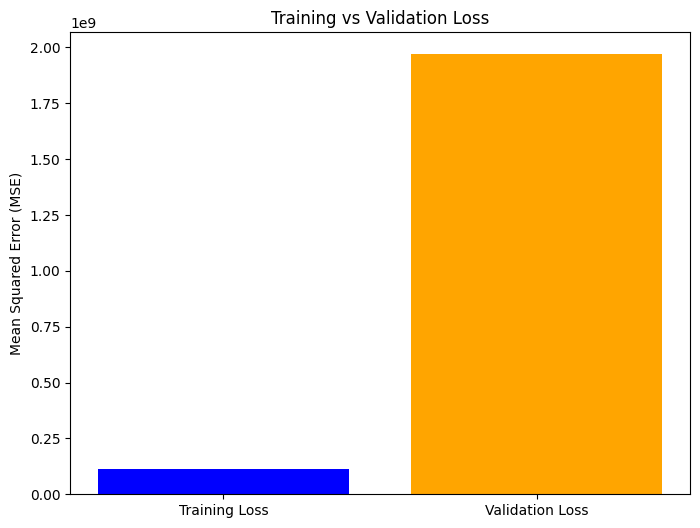

In [57]:
from matplotlib import pyplot as plt

# Vẽ biểu đồ thể hiện train_loss và test_loss để kiểm tra overfitting
plt.figure(figsize=(8, 6))
plt.bar(['Training Loss', 'Validation Loss'], [train_loss, test_loss], color=['blue', 'orange'])
plt.title('Training vs Validation Loss')
plt.ylabel('Mean Squared Error (MSE)')
plt.show()

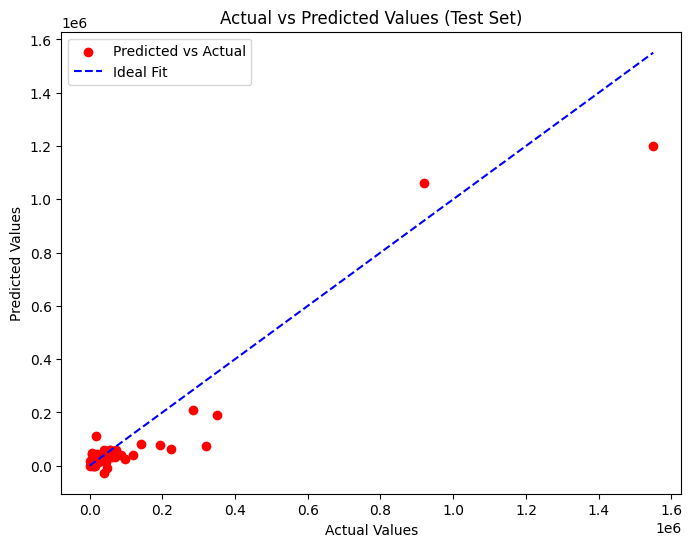

In [55]:
# Kiểm tra độ chính xác của dự đoán bằng biểu đồ scatter plot giữa giá trị thực và giá trị dự đoán
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='red', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Test Set)')
plt.legend()
plt.show()